In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from time import time
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('Sales_Data - Sales_Data.csv', parse_dates=['Order Date'], index_col='Order Date')
data.head()

,Customer ID,Category,Sub-Category,Sales,Quantity,Discount,Marketing,Sales Compensation,Returned
Order Date,,,,,,,,,
2014-05-10,AH-690134,Office Supplies,Storage,13.2000,2,0.60,0.00,1.42,False
2012-08-15,AM-10360139,Technology,Phones,4453.0500,7,0.00,1424.85,433.41,False
2015-08-29,BV-1124528,Furniture,Tables,2320.6400,5,0.20,0.00,130.77,False
2015-05-07,TC-21475130,Technology,Accessories,346.5882,9,0.47,0.00,21.13,False
2013-05-10,BW-1111058,Technology,Accessories,334.6800,4,0.00,83.64,63.87,False


In [3]:
data.describe()

,Sales,Quantity,Discount,Marketing,Sales Compensation
count,35903.000000,35903.000000,35903.000000,35903.000000,35903.000000
mean,246.403639,3.480879,0.141811,46.405926,26.401792
std,475.880762,2.283038,0.211654,138.490419,56.200568
min,0.444000,1.000000,0.000000,0.000000,1.002000
25%,30.827250,2.000000,0.000000,0.000000,2.620000
50%,85.920000,3.000000,0.000000,9.300000,7.790000
75%,253.720760,5.000000,0.200000,36.908500,24.725000
max,17499.950000,14.000000,0.850000,8399.976000,923.630000


In [4]:
mask = data['Returned'] == False

In [5]:
data = data[(mask)]
data.head()

,Customer ID,Category,Sub-Category,Sales,Quantity,Discount,Marketing,Sales Compensation,Returned
Order Date,,,,,,,,,
2014-05-10,AH-690134,Office Supplies,Storage,13.2000,2,0.60,0.00,1.42,False
2012-08-15,AM-10360139,Technology,Phones,4453.0500,7,0.00,1424.85,433.41,False
2015-08-29,BV-1124528,Furniture,Tables,2320.6400,5,0.20,0.00,130.77,False
2015-05-07,TC-21475130,Technology,Accessories,346.5882,9,0.47,0.00,21.13,False
2013-05-10,BW-1111058,Technology,Accessories,334.6800,4,0.00,83.64,63.87,False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34082 entries, 2014-05-10 to 2013-07-05
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         34082 non-null  object 
 1   Category            34082 non-null  object 
 2   Sub-Category        34082 non-null  object 
 3   Sales               34082 non-null  float64
 4   Quantity            34082 non-null  int64  
 5   Discount            34082 non-null  float64
 6   Marketing           34082 non-null  float64
 7   Sales Compensation  34082 non-null  float64
 8   Returned            34082 non-null  bool   
dtypes: bool(1), float64(4), int64(1), object(3)
memory usage: 2.4+ MB


### Looking at the categories

In [7]:
data['Category'].unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [8]:
# number of sales by category

data.groupby('Category')['Sales'].count()

Category
Furniture           6474
Office Supplies    20777
Technology          6831
Name: Sales, dtype: int64

### Exploratory Data Analysis

#### Aggreagte sales

In [9]:
# Aggregate monthly sales
sales = data[['Sales']].resample('M').sum()
sales.head()

,Sales
Order Date,
2012-01-31,70493.03426
2012-02-29,64908.86004
2012-03-31,81226.77890
2012-04-30,68103.62618
2012-05-31,100123.80590


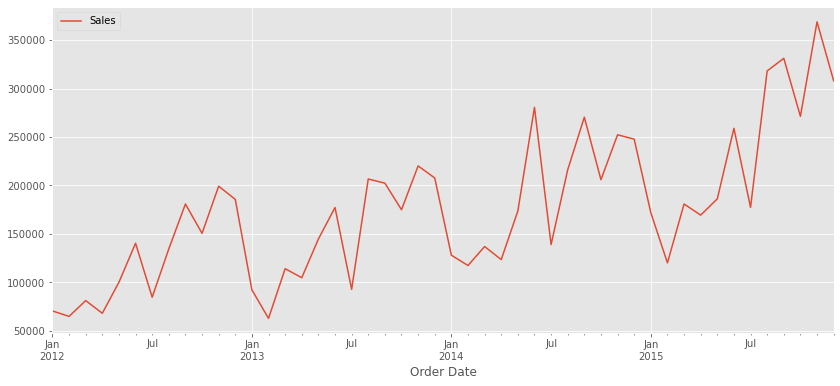

In [10]:
sales.plot(figsize=(14,6))

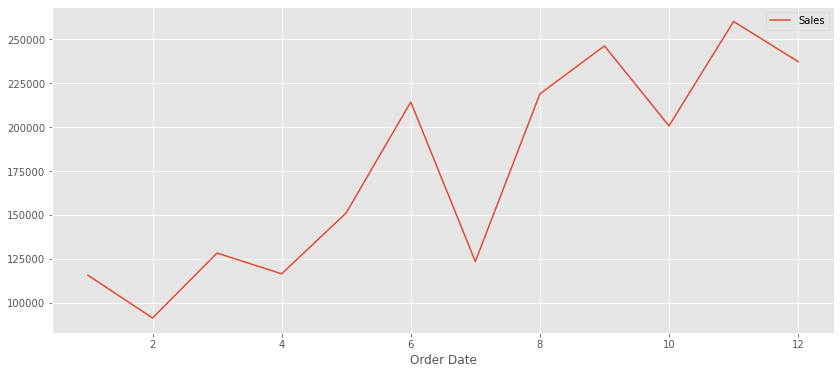

In [11]:
months = sales.index.month
mean_sales_by_m = sales.groupby(months).mean()
mean_sales_by_m.plot(figsize=(14,6))

Most of the sales transactions have been being carried out in the second half of the year. While November has the highest average monthly sales, February is recorded as the lowest.

#### By category

In [12]:
tech = data[data['Category'] == 'Technology'][['Sales']]
tech_ms = tech.resample('M').sum()

furniture = data[data['Category'] == 'Furniture'][['Sales']]
furniture_ms = furniture.resample('M').sum()

office = data[data['Category'] == 'Office Supplies'][['Sales']]
office_ms = office.resample('M').sum()

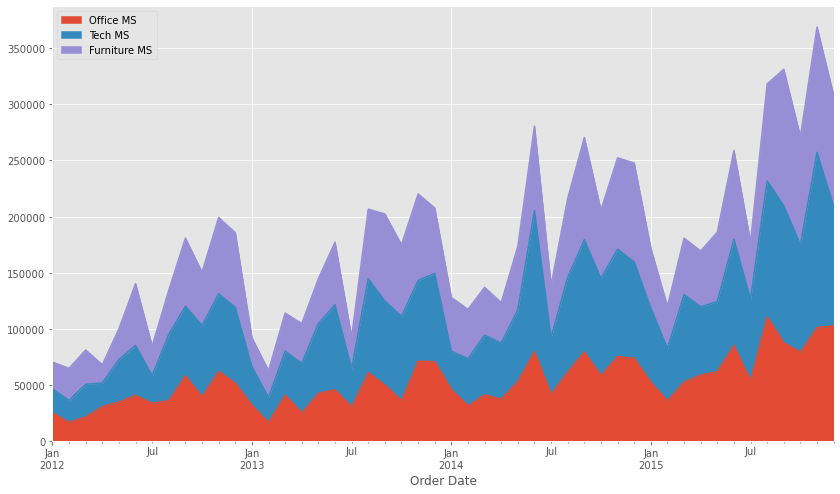

In [13]:
dfs = [office_ms, tech_ms, furniture_ms]

from functools import reduce
sales_by_cat = reduce(lambda left,right: pd.merge(left,right,on='Order Date'), dfs).rename(columns={'Sales_x':'Office MS', 
                                                                                                    'Sales_y': 'Tech MS', 
                                                                                                    'Sales': 'Furniture MS'})

fig, ax = plt.subplots(figsize=(14,8))
sales_by_cat.plot.area(ax=ax, fontsize=10)
plt.show()

# Predicting technology sales

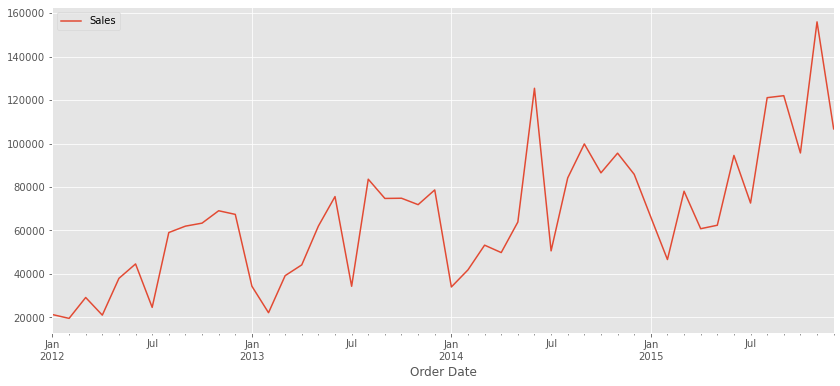

In [14]:
tech_ms.plot(figsize=(14,6));

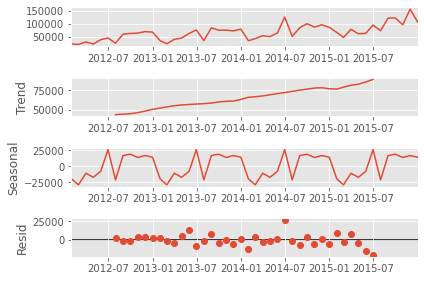

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(tech_ms, period=12).plot();

### Splitting the dataframe into test and train

In [16]:
df_train = tech_ms[:len(tech_ms)-11]
df_test = tech_ms[(len(tech_ms)-11):]

### Testing for stationarity

In [17]:
adfuller(df_train)

(-3.5551464552289986,
 0.006678752703922031,
 0,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 599.2535285879944)

In [18]:
df_train_diff = df_train.diff().dropna()

In [19]:
adfuller(df_train_diff)

(-7.068549538021733,
 5.006393030888708e-10,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 553.8903525636654)

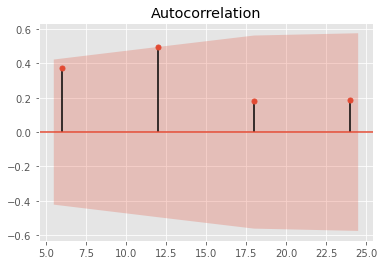

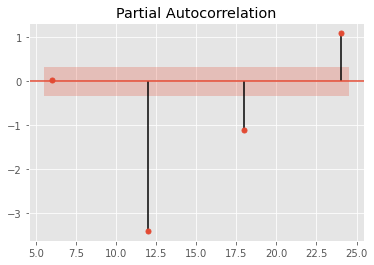

In [20]:
plot_acf(df_train_diff, zero=False, lags=[6,12,18,24]);
plot_pacf(df_train_diff, zero=False, lags=[6,12,18,24]);

### Searching over model orders

In [21]:
import pmdarima as pm

results = pm.auto_arima(df_train, d=1, seasonal=True, m=12, D=1, information_criterion='aic')
results

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

### Fitting the model

In [22]:
model = SARIMAX(df_train, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
results = model.fit()

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   37
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -267.114
Date:                            Mon, 31 May 2021   AIC                            538.228
Time:                                    00:03:45   BIC                            540.584
Sample:                                01-31-2012   HQIC                           538.853
                                     - 01-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3269      0.112     -2.909      0.004      -0.547      -0.107
sigma2      2.317e+08   4.64e-11      5e+18      0.000    2.32e+08    2.32e+08
===================================================================================
Ljung-Box (Q):                       26.83   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.26   Prob(JB):                         0.31
Heteroskedasticity (H):               2.64   Skew:                             0.64
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

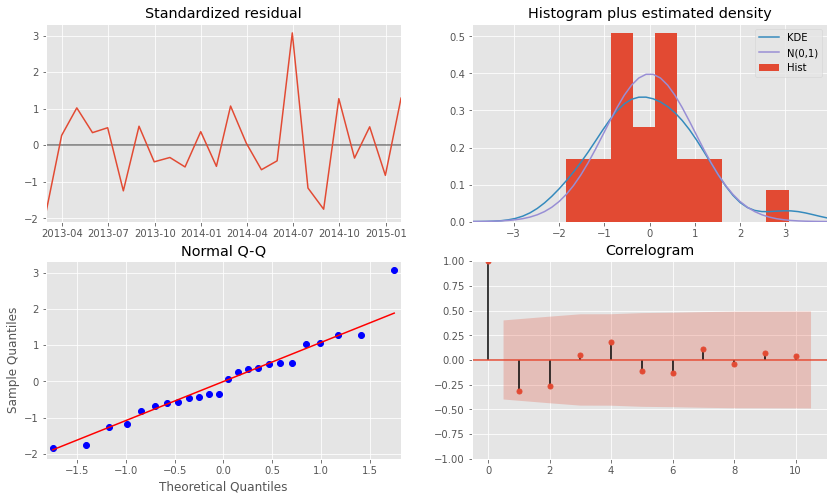

In [24]:
results.plot_diagnostics(figsize=(14,8));

### Getting the forecast

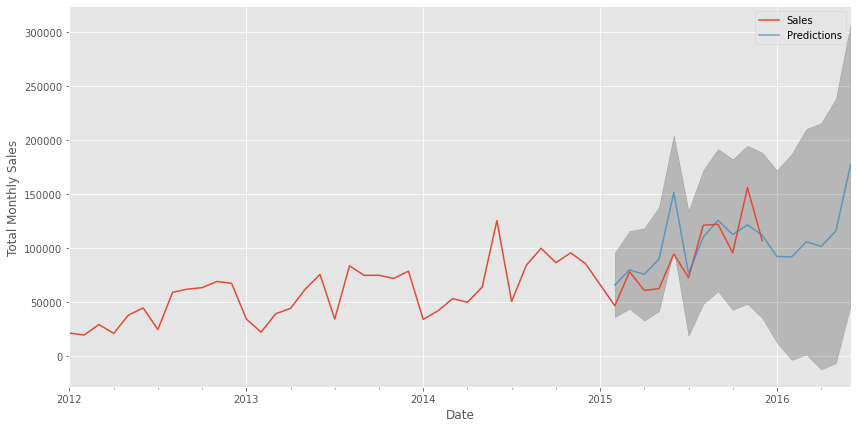

In [25]:
forecast = results.get_forecast(steps=17)

predictions = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

# observed plot
fig = tech_ms.plot(label='observed', figsize=(14,7))
fig.set_xlabel('Date')
fig.set_ylabel('Total Monthly Sales')
fig.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.2)

# prediction plot
predictions.plot(ax=fig, label='Predictions', alpha=0.7, figsize=(14,7))
plt.legend();

In [26]:
predictions.tail(6)

2016-01-31     92176.861864
2016-02-29     91891.392178
2016-03-31    105925.775690
2016-04-30    101641.060760
2016-05-31    115989.788691
2016-06-30    177475.640357
Freq: M, dtype: float64

In [27]:
# import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt

actual = df_test['2015-02-28':].values
predicted = predictions[:'2015-12-31'].values

rmse = sqrt(mean_squared_error(actual, predicted))
print(rmse)

23814.07768470436


# Predicting furniture sales

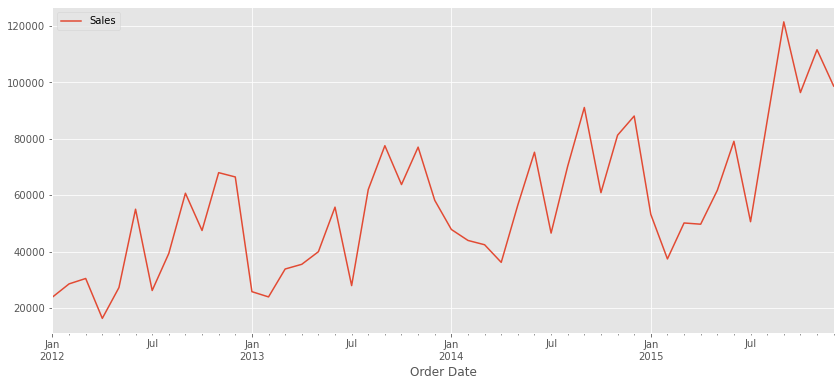

In [28]:
furniture_ms.plot(figsize=(14,6));

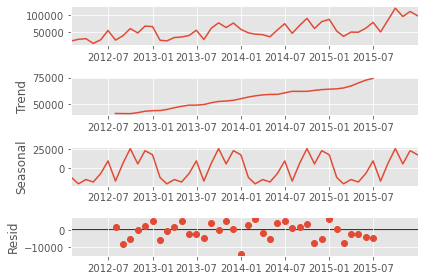

In [29]:
seasonal_decompose(furniture_ms, period=12).plot();

### Splitting the dataframe into test and train

In [30]:
df_train = furniture_ms[:len(furniture_ms)-11]
df_test = furniture_ms[(len(furniture_ms)-11):]

### Testing for stationarity

In [31]:
adfuller(df_train)

(0.45345005128777105,
 0.9833874238648301,
 10,
 26,
 {'1%': -3.7112123008648155,
  '5%': -2.981246804733728,
  '10%': -2.6300945562130176},
 573.7202266930402)

In [32]:
df_train_diff = df_train.diff().dropna()

In [33]:
adfuller(df_train_diff)

(-4.678722343773147,
 9.22486113513887e-05,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 544.292662460982)

### Searching over model orders

In [34]:
results = pm.auto_arima(df_train, d=1, seasonal=True, m=12, information_criterion='aic')
results

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

### Fitting the model

In [35]:
model = SARIMAX(df_train, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12))
results = model.fit()

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   37
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -255.261
Date:                            Mon, 31 May 2021   AIC                            514.521
Time:                                    00:03:52   BIC                            516.877
Sample:                                01-31-2012   HQIC                           515.146
                                     - 01-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4613      0.144     -3.204      0.001      -0.743      -0.179
sigma2       1.01e+08   2.31e-10   4.36e+17      0.000    1.01e+08    1.01e+08
===================================================================================
Ljung-Box (Q):                       19.57   Jarque-Bera (JB):                 1.56
Prob(Q):                              0.67   Prob(JB):                         0.46
Heteroskedasticity (H):               0.68   Skew:                             0.55
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

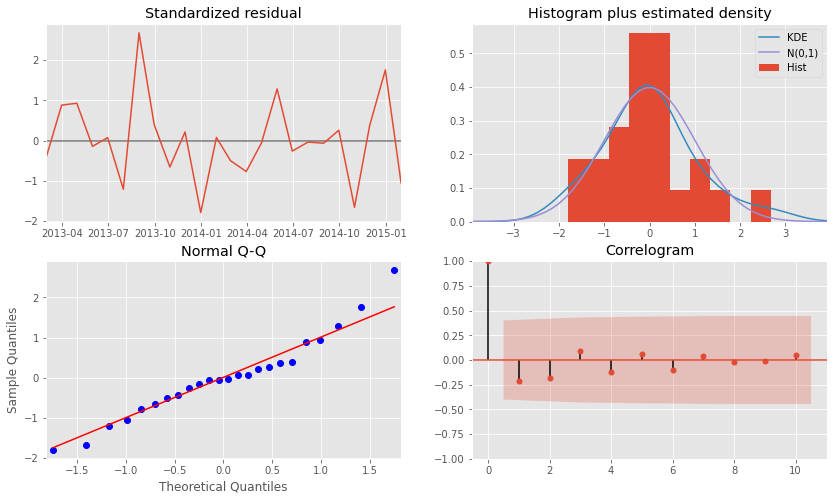

In [37]:
results.plot_diagnostics(figsize=(14,8));

### Getting the forecast

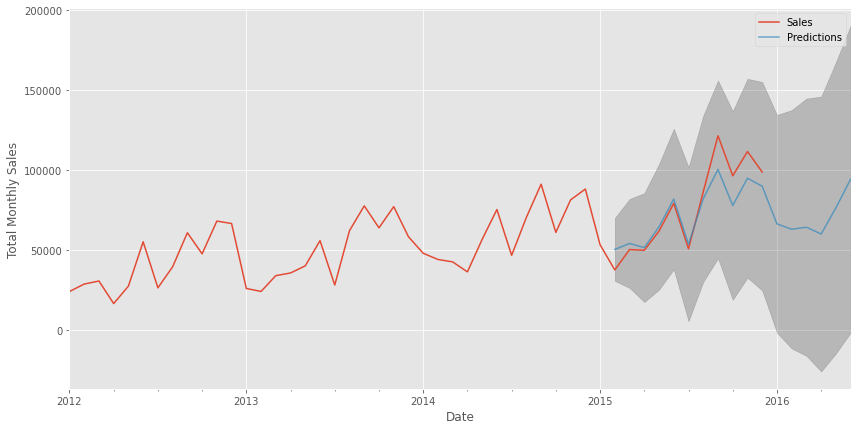

In [38]:
forecast = results.get_forecast(steps=17)

predictions = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

# observed plot
fig = furniture_ms.plot(label='observed', figsize=(14,7))
fig.set_xlabel('Date')
fig.set_ylabel('Total Monthly Sales')
fig.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.2)

# prediction plot
predictions.plot(ax=fig, label='Predictions', alpha=0.7, figsize=(14,7))
plt.legend();

In [39]:
predictions.tail(6)

2016-01-31    66245.787727
2016-02-29    62862.331522
2016-03-31    64173.216879
2016-04-30    59890.407036
2016-05-31    76293.603566
2016-06-30    94262.876601
Freq: M, dtype: float64

In [40]:
actual = df_test['2015-02-28':].values
predicted = predictions[:'2015-12-31'].values

rmse = sqrt(mean_squared_error(actual, predicted))
print(rmse)

11180.131188834659


# Predicting the sales of office supplies 

### Preparing the dataframe

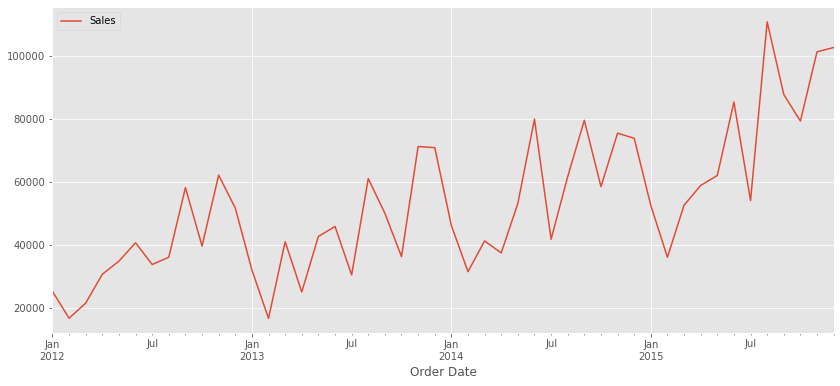

In [41]:
office_ms.plot(figsize=(14,6));

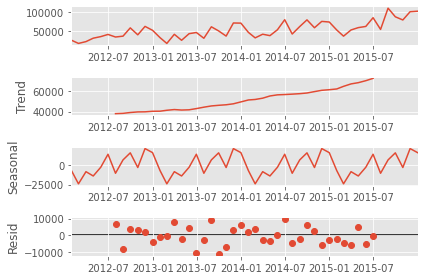

In [42]:
seasonal_decompose(office_ms, period=12).plot();

### Splitting the dataframe into test and train

In [43]:
df_train = office_ms[:len(office_ms)-11]
df_test = office_ms[(len(office_ms)-11):]

### Testing for stationarity

In [44]:
adfuller(df_train)

(-3.615662776986321,
 0.00546855325582333,
 0,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 581.072799347783)

In [45]:
df_train_diff = df_train.diff().dropna()

In [46]:
adfuller(df_train_diff)

(-4.638255238365258,
 0.00010974594377320726,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 553.6273084089102)

### Searching over model orders

In [47]:
import pmdarima as pm

In [48]:
results = pm.auto_arima(df_train, d=1, seasonal=True, m=12, information_criterion='aic')
results

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

### Fitting the model

In [49]:
model = SARIMAX(df_train, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12))
results = model.fit()

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   37
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -261.882
Date:                             Mon, 31 May 2021   AIC                            529.764
Time:                                     00:03:59   BIC                            533.298
Sample:                                 01-31-2012   HQIC                           530.702
                                      - 01-31-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5427      0.126     -4.293      0.000      -0.790      -0.295
ar.S.L12      -0.3311      0.186     -1.782      0.075      -0.695       0.033
sigma2      1.523e+08    1.6e-10   9.53e+17      0.000    1.52e+08    1.52e+08
===================================================================================
Ljung-Box (Q):                       10.67   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.99   Prob(JB):                         0.81
Heteroskedasticity (H):               0.54   Skew:                             0.28
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+33. Standard errors may be unstable.
"""

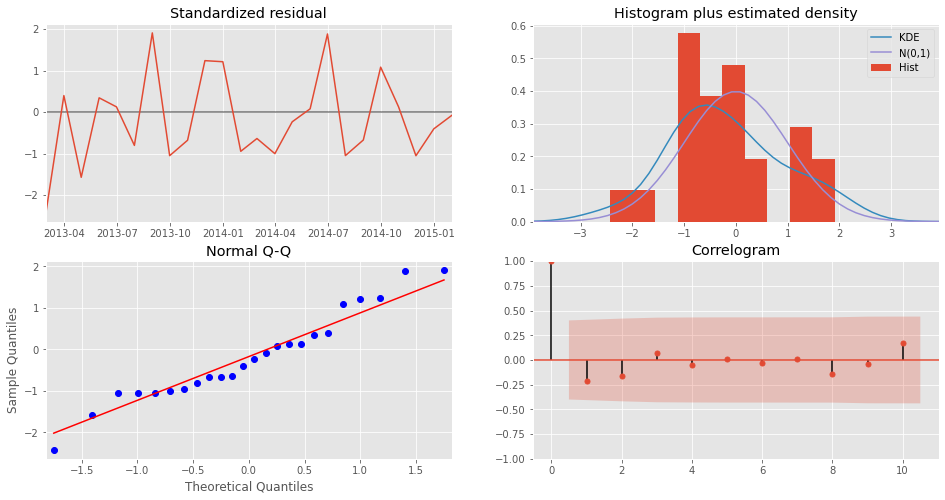

In [51]:
results.plot_diagnostics(figsize=(16,8));

### Getting the forecast

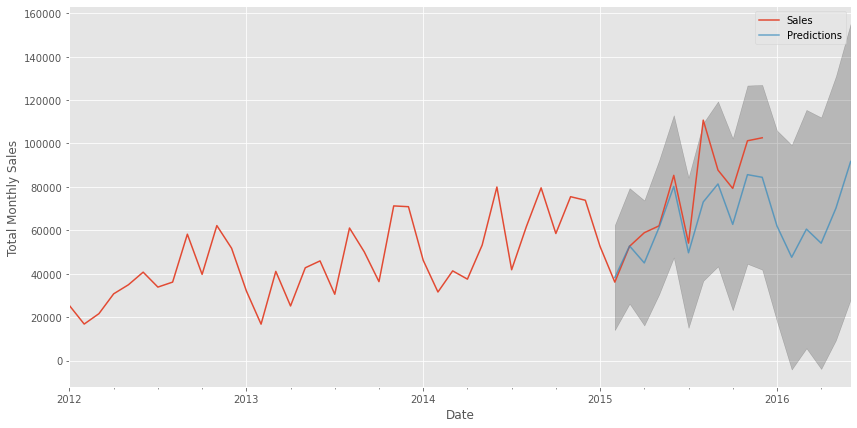

In [52]:
forecast = results.get_forecast(steps=17)

predictions = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

# observed plot
fig = office_ms.plot(label='observed', figsize=(14,7))
fig.set_xlabel('Date')
fig.set_ylabel('Total Monthly Sales')
fig.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.2)

# prediction plot
predictions.plot(ax=fig, label='Predictions', alpha=0.7, figsize=(14,7))
plt.legend();

In [53]:
predictions.tail(6)

2016-01-31    61999.119537
2016-02-29    47574.199953
2016-03-31    60539.939342
2016-04-30    54048.823018
2016-05-31    70154.446908
2016-06-30    91680.292339
Freq: M, dtype: float64

In [54]:
actual = df_test['2015-02-28':].values
predicted = predictions[:'2015-12-31'].values

rmse = sqrt(mean_squared_error(actual, predicted))
print(rmse)

15236.720169628588


# Predicting Aggregate Sales

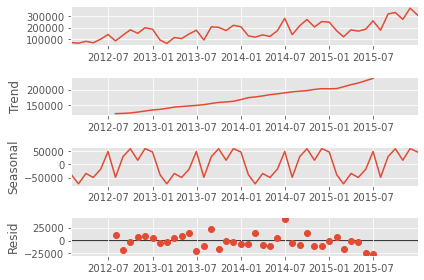

In [55]:
seasonal_decompose(sales, period=12).plot();

### Splitting the dataframe into test and train

In [56]:
df_train = sales[:len(sales)-11]
df_test = sales[(len(sales)-11):]

### Testing for stationarity

In [57]:
adfuller(df_train)

(-0.07815592549579445,
 0.951571288789016,
 9,
 27,
 {'1%': -3.6996079738860943,
  '5%': -2.9764303469999494,
  '10%': -2.627601001371742},
 637.7243194417596)

In [58]:
df_train_diff = df_train.diff().dropna()

In [59]:
adfuller(df_train_diff)

(-7.540147959763561,
 3.395045029015519e-11,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 587.5878884176278)

In [60]:
results = pm.auto_arima(df_train, d=1, seasonal=True, m=12, information_criterion='aic')
results

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

### Fitting the model

In [61]:
model = SARIMAX(df_train, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   37
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -283.384
Date:                            Mon, 31 May 2021   AIC                            570.769
Time:                                    00:04:04   BIC                            573.125
Sample:                                01-31-2012   HQIC                           571.394
                                     - 01-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1477      0.089     -1.659      0.097      -0.322       0.027
sigma2      8.834e+08   1.12e-12   7.89e+20      0.000    8.83e+08    8.83e+08
===================================================================================
Ljung-Box (Q):                       29.04   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.18   Prob(JB):                         0.61
Heteroskedasticity (H):               1.42   Skew:                             0.50
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

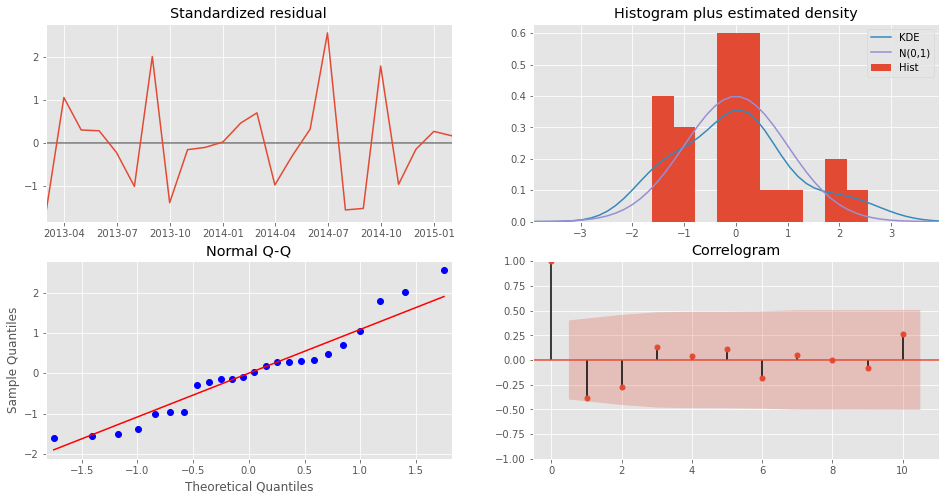

In [62]:
results.plot_diagnostics(figsize=(16,8));

### Getting the forecasts

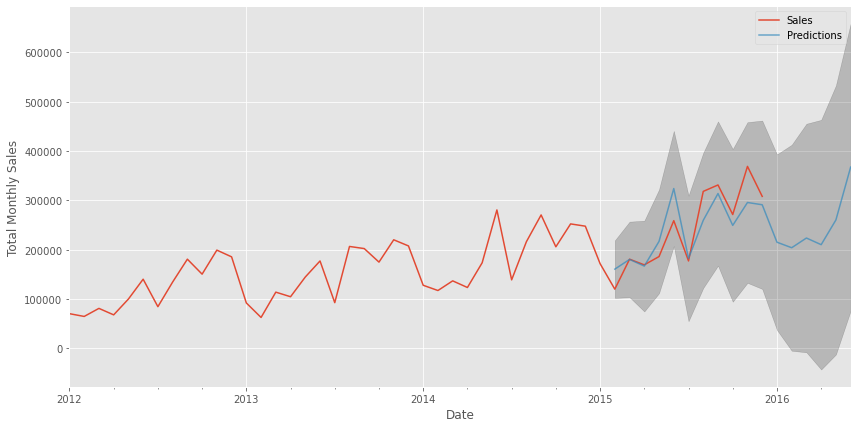

In [63]:
forecast = results.get_forecast(steps=17)

predictions = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

# observed plot
fig = sales.plot(label='observed', figsize=(14,7))
fig.set_xlabel('Date')
fig.set_ylabel('Total Monthly Sales')
fig.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.2)

# prediction plot
predictions.plot(ax=fig, label='Predictions', alpha=0.7, figsize=(14,7))
plt.legend();

In [64]:
predictions.tail(6)

2016-01-31    215286.060031
2016-02-29    204089.996542
2016-03-31    223751.421848
2016-04-30    210269.529736
2016-05-31    260371.344456
2016-06-30    367385.292044
Freq: M, dtype: float64

In [65]:
actual = df_test['2015-02-28':].values
predicted = predictions[:'2015-12-31'].values

rmse = sqrt(mean_squared_error(actual, predicted))
print(rmse)

38986.77939575563
